In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

# バージョンの情報
import platform
print('The python version is {}.'.format(platform.python_version()))
print('The numpy version is {}.'.format(np.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The python version is 3.6.9.
The numpy version is 1.18.4.
The scikit-learn version is 0.22.2.post1.


# データセットの作成用関数
* sin関数に正規分布のノイズを加えたデータセットを生成する関数
* $0 \leq x \leq 2\pi$ の範囲に等間隔にdata_num個のデータを生成する
* sigmaは正規分布の標準偏差

In [0]:
def create_dataset(data_num, sigma=0.3):
    X = np.linspace(0, 2*np.pi, num=data_num)
    t = np.sin(X) + sigma * np.random.randn(data_num)
    return X, t

## 評価指標を計算する関数
* 決定係数（$R^2$ score）
* 平方根平均二乗誤差（Root mean squre error; RMSE）
* 平均絶対誤差（Mean Absolute Error; MAE）

In [0]:
# t: 正解値，y: 予測値
def RMSE(t, y):
    return np.sqrt(np.mean((y - t)**2))

def R2(t, y):
    return 1 - np.sum((y - t)**2) / np.sum((t - np.mean(t))**2)

def MAE(t, y):
    return np.mean(np.abs(y - t))

# リッジ回帰（自作）

##モデルの定義

In [0]:
class LinearRegression(object):    
    # モデルの訓練
    # X: 学習データの入力変数
    # t: 学習データの目的変数
    # lam: 正則化係数
    def fit(self, X, t, lam=0.):
        d = X.shape[1]
        XX = np.dot(X.T, X)
        # numpy.linalg.solveで解く
        self.w = np.linalg.solve(XX + lam * np.identity(d), np.dot(X.T, t))
    
    # 新しいデータの予測
    # X: 入力変数
    def predict(self, X):
        return np.dot(X, self.w)

## 基底関数の定義

### 多項式

In [0]:
# x^0 から x^(M-1)までの基底関数の値を返す
class Polynomial(object):
    def __init__(self, M=1):
        self.M = M
    
    # Xは （データ数 x 1）もしくは（データ数）のサイズの配列
    def __call__(self, X):
        return np.array([X.flatten()**i for i in range(self.M)]).T

### ガウス基底関数

In [0]:
class GaussianBasis(object):
    def __init__(self, baseMu, s=1.0):
        self.baseMu = baseMu
        self.s = s
    
    # Xは （データ数 x 特徴数）のサイズの配列
    def __call__(self, X):
        if len(X.shape) == 1:
            X = X[:, np.newaxis]
        gbasis = np.array([np.exp(- np.sum((X - mu)**2, axis=1) / (2 * self.s**2)) for mu in self.baseMu]).T
        return gbasis

# データの作成

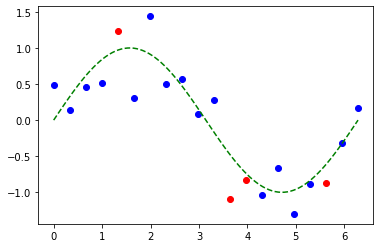

In [7]:
# 乱数シードの固定
np.random.seed(1)

# データの作成
N = 20
orgX, org_t = create_dataset(N)

index = np.arange(N)
np.random.shuffle(index)

# 訓練データ（8割を訓練データに）
X_train, t_train = orgX[index[:int(0.8*N)]], org_t[index[:int(0.8*N)]]
# テスト用データ（残りの2割）
X_test, t_test = orgX[index[int(0.8*N):]], org_t[index[int(0.8*N):]]

# 訓練用データのプロット
plt.scatter(X_train, t_train, marker='o', color='blue', label=None)
# テスト用データのプロット
plt.scatter(X_test, t_test, marker='o', color='red', label=None)
# 真の曲線を表示
XX, tt = create_dataset(100, sigma=0.)
plt.plot(XX, tt, color='green', linestyle='--')
plt.show()

# モデルの学習例（多項式回帰）

<Figure size 432x288 with 0 Axes>

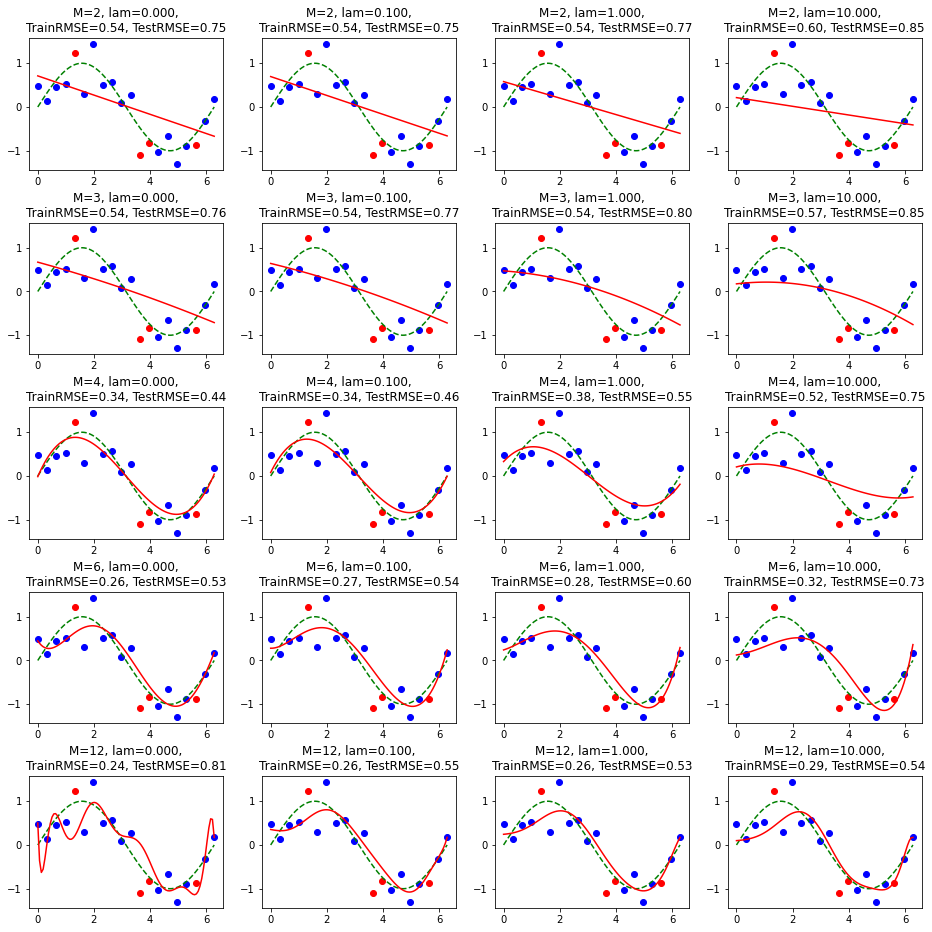

In [8]:
lams = [0.0, 0.1, 1.0, 10.0]  # 正則化係数
Ms = [2, 3, 4, 6, 12]  # 次数

plt.clf()
fig = plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4)

i = 0
for M in Ms:
    for lam in lams:
        # リッジ回帰モデルの学習
        Phi = Polynomial(M=M)
        lr_model = LinearRegression()
        lr_model.fit(Phi(X_train), t_train, lam=lam)

        # 予測曲線の取得
        XX, tt = create_dataset(100, sigma=0.)
        yy = lr_model.predict(Phi(XX))

        # 予測値の計算
        y_train = lr_model.predict(Phi(X_train))
        y_test = lr_model.predict(Phi(X_test))

        # プロット
        subplt = fig.add_subplot(len(Ms), len(lams), i+1)
        subplt.set_title('M=%d, lam=%.3f,\nTrainRMSE=%.2f, TestRMSE=%.2f'%(M, lam, RMSE(t_train, y_train), RMSE(t_test, y_test)))
        subplt.scatter(X_train, t_train, marker='o', color='blue', label=None)
        subplt.scatter(X_test, t_test, marker='o', color='red', label=None)
        subplt.plot(XX, tt, color='green', linestyle='--')
        subplt.plot(XX, yy, color='red')  # 予測曲線を表示

        i += 1

plt.show()

# モデルの学習例（ガウス基底関数の場合）

<Figure size 432x288 with 0 Axes>

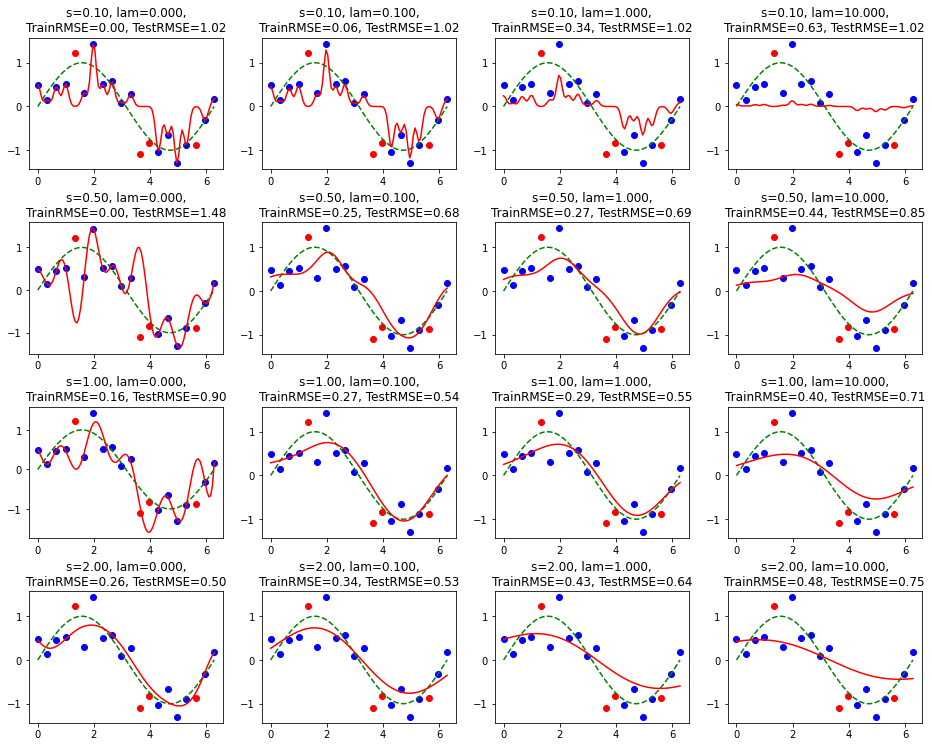

In [9]:
lams = [0.0, 0.1, 1.0, 10.0]  # 正則化係数
ss = [0.1, 0.5, 1.0, 2.0]

plt.clf()
fig = plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4)

i = 0
for s in ss:
    for lam in lams:
        # リッジ回帰モデルの学習
        Phi = GaussianBasis(X_train, s=s)
        lr_model = LinearRegression()
        lr_model.fit(Phi(X_train), t_train, lam=lam)

        # 予測曲線の取得
        XX, tt = create_dataset(100, sigma=0.)
        yy = lr_model.predict(Phi(XX))

        # 予測値の計算
        y_train = lr_model.predict(Phi(X_train))
        y_test = lr_model.predict(Phi(X_test))

        # プロット
        subplt = fig.add_subplot(len(Ms), len(lams), i+1)
        subplt.set_title('s=%.2f, lam=%.3f,\nTrainRMSE=%.2f, TestRMSE=%.2f'%(s, lam, RMSE(t_train, y_train), RMSE(t_test, y_test)))
        subplt.scatter(X_train, t_train, marker='o', color='blue', label=None)
        subplt.scatter(X_test, t_test, marker='o', color='red', label=None)
        subplt.plot(XX, tt, color='green', linestyle='--')
        subplt.plot(XX, yy, color='red')  # 予測曲線を表示

        i += 1

plt.show()

# pythonの機械学習ライブラリscikit-learnを使った場合のリッジ回帰
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

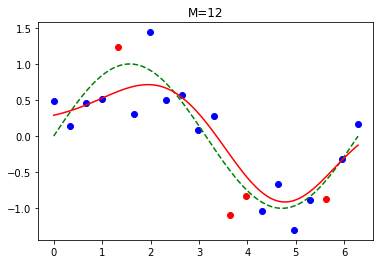

（学習データ）RMSE: 0.283, MAE: 0.222, R2: 0.832
（テストデータ）RMSE: 0.559, MAE: 0.511, R2: 0.648
係数：[-2.47745614e-01  1.22157358e-01  1.23120948e-01  2.31186847e-04
  1.56550030e-01  1.55129931e-01 -3.26773807e-01 -8.49387541e-04
 -3.47624220e-01 -3.11353721e-01  4.13195782e-03  5.58383038e-02
  3.08708232e-02  9.65989944e-03  1.04666036e-01 -3.34851039e-02]


In [10]:
import sklearn.linear_model as sk_lm
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

lam = 1.
Phi = GaussianBasis(X_train, s=1.)  # ガウス基底関数
lr_model = sk_lm.Ridge(alpha=lam)  # alphaに正則化係数を指定する
lr_model.fit(Phi(X_train), t_train)

# 予測曲線の取得
XX, tt = create_dataset(100, sigma=0.)
yy = lr_model.predict(Phi(XX))

# プロット
plt.title('M=%d'%(M))
plt.scatter(X_train, t_train, marker='o', color='blue', label=None)
plt.scatter(X_test, t_test, marker='o', color='red', label=None)
plt.plot(XX, tt, color='green', linestyle='--')
plt.plot(XX, yy, color='red')  # 予測曲線を表示
plt.show()

# 評価指標の表示
y_train = lr_model.predict(Phi(X_train))
y_test = lr_model.predict(Phi(X_test))
# Scikit-learnの機能を使ってスコアを算出
print('（学習データ）RMSE: %.3f, MAE: %.3f, R2: %.3f'%(np.sqrt(mean_squared_error(t_train, y_train)), mean_absolute_error(t_train, y_train), r2_score(t_train, y_train)))
print('（テストデータ）RMSE: %.3f, MAE: %.3f, R2: %.3f'%(np.sqrt(mean_squared_error(t_test, y_test)), mean_absolute_error(t_test, y_test), r2_score(t_test, y_test)))
print('係数：' + str(lr_model.coef_))

# Lasso
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

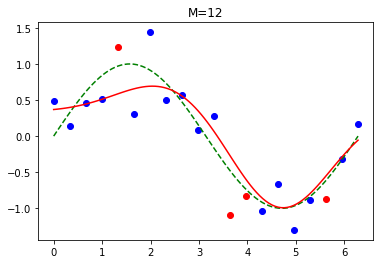

（学習データ）RMSE: 0.276, MAE: 0.208, R2: 0.841
（テストデータ）RMSE: 0.561, MAE: 0.508, R2: 0.645
係数：[-0.          0.          0.          0.          0.4084925   0.
 -0.29737998 -0.         -1.07067832 -0.         -0.          0.
 -0.         -0.          0.          0.        ]


In [11]:
import sklearn.linear_model as sk_lm
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

lam = 0.01
Phi = GaussianBasis(X_train, s=1.)  # ガウス基底関数
lr_model = sk_lm.Lasso(alpha=lam)
lr_model.fit(Phi(X_train), t_train)

# 予測曲線の取得
XX, tt = create_dataset(100, sigma=0.)
yy = lr_model.predict(Phi(XX))

# プロット
plt.title('M=%d'%(M))
plt.scatter(X_train, t_train, marker='o', color='blue', label=None)
plt.scatter(X_test, t_test, marker='o', color='red', label=None)
plt.plot(XX, tt, color='green', linestyle='--')
plt.plot(XX, yy, color='red')  # 予測曲線を表示
plt.show()

# 評価指標の表示
y_train = lr_model.predict(Phi(X_train))
y_test = lr_model.predict(Phi(X_test))
# Scikit-learnの機能を使ってスコアを算出
print('（学習データ）RMSE: %.3f, MAE: %.3f, R2: %.3f'%(np.sqrt(mean_squared_error(t_train, y_train)), mean_absolute_error(t_train, y_train), r2_score(t_train, y_train)))
print('（テストデータ）RMSE: %.3f, MAE: %.3f, R2: %.3f'%(np.sqrt(mean_squared_error(t_test, y_test)), mean_absolute_error(t_test, y_test), r2_score(t_test, y_test)))
print('係数：' + str(lr_model.coef_))

# 交差検証（Cross validation）
* https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-and-model-selection
* ここではKFoldを使う（他にも交差検証に関する色々な機能がScikit Learnには用意されています）

In [12]:
from sklearn.model_selection import KFold

# 動作確認のためのチェック
X = ['a', 'b', 'c', 'd', 'e']
kf = KFold(n_splits=3, shuffle=True, random_state=0)  # 分割数を指定
for train, valid in kf.split(X):
    print("%s %s" % (train, valid))

[1 3 4] [0 2]
[0 2 4] [1 3]
[0 1 2 3] [4]


In [13]:
# 乱数シードの固定
np.random.seed(1)
# データの作成
N = 20
orgX, org_t = create_dataset(N)
index = np.arange(N)
np.random.shuffle(index)

# 訓練データ（8割を訓練データに）
X_train, t_train = orgX[index[:int(0.8*N)]], org_t[index[:int(0.8*N)]]
# テスト用データ（残りの2割）
X_test, t_test = orgX[index[int(0.8*N):]], org_t[index[int(0.8*N):]]


# ハイパーパラメータの候補
Ms = [2, 3, 4, 6, 12]  # 次数
lams = [0.0, 0.1, 1.0, 10.0]  # 正則化係数

# 交差検証（訓練データの中でCVを行う）
kf = KFold(n_splits=8, shuffle=True, random_state=0)

optM, optlam = 0, 0
meanRMSE = np.inf

for M in Ms:
    for lam in lams:
        rmse = []
        for i, (train, valid) in enumerate(kf.split(X_train)):
            # リッジ回帰モデルの学習
            Phi = Polynomial(M=M)
            lr_model = LinearRegression()
            lr_model.fit(Phi(X_train[train]), t_train[train], lam=lam)

            # Validationデータの予測値の計算
            y_valid = lr_model.predict(Phi(X_train[valid]))

            # 評価指標を計算
            rmse.append(RMSE(t_train[valid], y_valid))
        print('M=%d, lam=%.3f, Average RMSE=%.3f (%s)'%(M, lam, np.mean(rmse), rmse))
        if meanRMSE > np.mean(rmse):
            meanRMSE = np.mean(rmse)
            optM, optlam = M, lam
print('opt M=%d, opt lam=%.3f'%(optM, optlam))

M=2, lam=0.000, Average RMSE=0.574 ([0.783263433437498, 0.7420366634998792, 0.2755305456927753, 0.7805429939436971, 0.4990005211749601, 0.22443159334599308, 0.37369209007702575, 0.9142029029590547])
M=2, lam=0.100, Average RMSE=0.571 ([0.7864273478098873, 0.7430069285807629, 0.2718768634509122, 0.7715760749122839, 0.4756010293450178, 0.22764672003647818, 0.3746114252459492, 0.9208387272919495])
M=2, lam=1.000, Average RMSE=0.560 ([0.8099710081733156, 0.7502618451132107, 0.2744727731882044, 0.7097089397968335, 0.32416227983649315, 0.2521229901122517, 0.38668989207085563, 0.969255248710255])
M=2, lam=10.000, Average RMSE=0.602 ([0.8883711186451007, 0.7762152827841264, 0.4499723600870311, 0.5586885438929102, 0.2282016760632113, 0.33092631440156256, 0.4753542542105008, 1.1114994020380469])
M=3, lam=0.000, Average RMSE=0.643 ([0.7824269881883061, 0.808000976932054, 0.3172657169434087, 1.136855347599523, 0.5544698702204636, 0.22813875451603452, 0.38527925055498646, 0.9354272602269721])
M=3, 

## 交差検証で選択したパラメータで再度学習し（全ての訓練データを使う），最終的な学習モデルを得る，その後，テストデータで評価

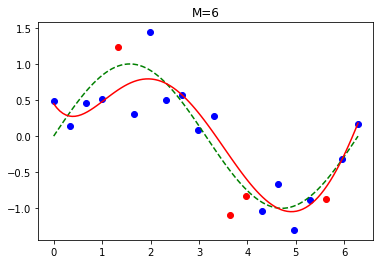

（学習データ）RMSE: 0.256, MAE: 0.189, R2: 0.862
（テストデータ）RMSE: 0.525, MAE: 0.456, R2: 0.689


In [14]:
M = optM
lam = optlam

# 線形回帰モデルの学習（訓練データ全てを使う）
Phi = Polynomial(M=M)
lr_model = LinearRegression()
lr_model.fit(Phi(X_train), t_train)

# 予測曲線の取得
XX, tt = create_dataset(100, sigma=0.)
yy = lr_model.predict(Phi(XX))

# プロット
plt.title('M=%d'%(M))
plt.scatter(X_train, t_train, marker='o', color='blue', label=None)
plt.scatter(X_test, t_test, marker='o', color='red', label=None)
plt.plot(XX, tt, color='green', linestyle='--')
plt.plot(XX, yy, color='red')  # 予測曲線を表示
plt.show()

# 評価指標の表示
y_train = lr_model.predict(Phi(X_train))
y_test = lr_model.predict(Phi(X_test))
print('（学習データ）RMSE: %.3f, MAE: %.3f, R2: %.3f'%(RMSE(t_train, y_train), MAE(t_train, y_train), R2(t_train, y_train)))
print('（テストデータ）RMSE: %.3f, MAE: %.3f, R2: %.3f'%(RMSE(t_test, y_test), MAE(t_test, y_test), R2(t_test, y_test)))

# Scikit-learnのモデルにはCVが付いているものがある
* 例えば，リッジ回帰正則化係数をCVで選択してくれる

In [15]:
Phi = Polynomial(M=6)

# デフォルトはLeave-One-Out cross-validation
# RidgeCVの場合alphaは0より大きくないといけない
#ridge_reg = sk_lm.RidgeCV(alphas=(0.00001, 0.1, 1.0, 10.0), scoring='neg_root_mean_squared_error')
ridge_reg = sk_lm.RidgeCV(alphas=(0.00001, 0.1, 1.0, 10.0), scoring='neg_root_mean_squared_error', cv=kf.split(X_train))

ridge_reg.fit(Phi(X_train), t_train)
print('Selected lambda=%f' % (ridge_reg.alpha_))

Selected lambda=0.000010


---

# 赤ワインのデータ

In [0]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=";", encoding="utf-8")

In [17]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 品質（quality）を予測する
t_org = df['quality'].values
X_org = df.drop(columns='quality').values
 
# データを学習用とテスト用に分割する（Scikit-learnの機能を使う）
X_train, X_test, t_train, t_test = train_test_split(X_org, t_org, test_size=0.2, random_state=0)

# 入力変数を標準化する（各変数が平均0，分散1になるようにスケーリング: (x - mean)/sigma）
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 乱数シードの固定
np.random.seed(1)
# データの作成
N = 20
orgX, org_t = create_dataset(N)
index = np.arange(N)
np.random.shuffle(index)

# 訓練データ（8割を訓練データに）
X_train, t_train = orgX[index[:int(0.8*N)]], org_t[index[:int(0.8*N)]]
# テスト用データ（残りの2割）
X_test, t_test = orgX[index[int(0.8*N):]], org_t[index[int(0.8*N):]]


# ハイパーパラメータの候補
Ms = [2, 3, 4, 6, 12]  # 次数
lams = [0.0, 0.1, 1.0, 10.0]  # 正則化係数

# 交差検証（訓練データの中でCVを行う）
kf = KFold(n_splits=5, shuffle=True, random_state=0)

optM, optlam = 0, 0
meanRMSE = np.inf

for M in Ms:
    for lam in lams:
        rmse = []
        for i, (train, valid) in enumerate(kf.split(X_train)):
            # リッジ回帰モデルの学習
            Phi = Polynomial(M=M)
            lr_model = LinearRegression()
            lr_model.fit(Phi(X_train[train]), t_train[train], lam=lam)

            # Validationデータの予測値の計算
            y_valid = lr_model.predict(Phi(X_train[valid]))

            # 評価指標を計算
            rmse.append(RMSE(t_train[valid], y_valid))
        print('M=%d, lam=%.3f, Average RMSE=%.3f (%s)'%(M, lam, np.mean(rmse), rmse))
        if meanRMSE > np.mean(rmse):
            meanRMSE = np.mean(rmse)
            optM, optlam = M, lam
print('opt M=%d, opt lam=%.3f'%(optM, optlam))

M=2, lam=0.000, Average RMSE=0.616 ([0.8917778035276838, 0.22849345038755892, 0.8652156243292718, 0.30713951743074386, 0.7896817245620777])
M=2, lam=0.100, Average RMSE=0.612 ([0.8935907398347092, 0.22379597256476902, 0.8409231634878789, 0.3054511401450361, 0.7952186053811038])
M=2, lam=1.000, Average RMSE=0.591 ([0.9070108572446541, 0.22880400524638073, 0.6884272105637791, 0.29573579802581934, 0.8353856154408575])
M=2, lam=10.000, Average RMSE=0.613 ([0.9490664011173215, 0.4160310460489964, 0.45671969392481043, 0.29192254676548746, 0.9532978344846743])
M=3, lam=0.000, Average RMSE=0.656 ([0.9453491060120585, 0.2603135559900091, 0.9524883477399456, 0.3098073185037747, 0.8110155987811823])
M=3, lam=0.100, Average RMSE=0.652 ([0.948677669441263, 0.23553778651962276, 0.9508117765315172, 0.3096760479305778, 0.8129672461994529])
M=3, lam=1.000, Average RMSE=0.646 ([0.9635132169003909, 0.18179755848493526, 0.9449783261361095, 0.3123183201511229, 0.8272621209389942])
M=3, lam=10.000, Average 

In [19]:
# 選択したハイパーパラメータで学習
M = optM
lam = optlam

# 線形回帰モデルの学習（訓練データ全てを使う）
Phi = Polynomial(M=M)
lr_model = LinearRegression()
lr_model.fit(Phi(X_train), t_train)

# 評価指標の表示
y_train = lr_model.predict(Phi(X_train))
y_test = lr_model.predict(Phi(X_test))
print('（学習データ）RMSE: %.3f, MAE: %.3f, R2: %.3f'%(RMSE(t_train, y_train), MAE(t_train, y_train), R2(t_train, y_train)))
print('（テストデータ）RMSE: %.3f, MAE: %.3f, R2: %.3f'%(RMSE(t_test, y_test), MAE(t_test, y_test), R2(t_test, y_test)))

（学習データ）RMSE: 0.256, MAE: 0.189, R2: 0.862
（テストデータ）RMSE: 0.525, MAE: 0.456, R2: 0.689
